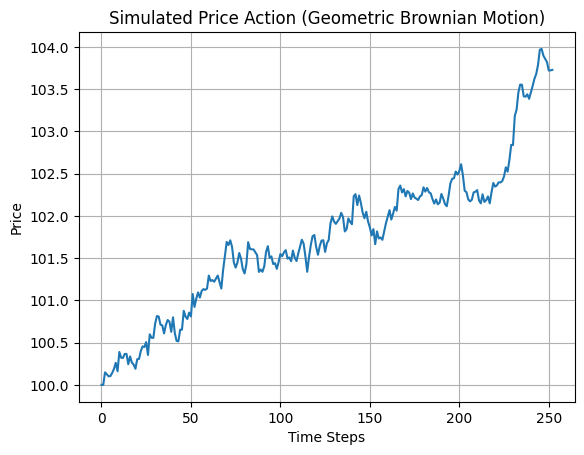

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Simulating Price Action via Geometric Brownian Motion 
def simulate_price_action(init_price, base_drift, sigma, time_in_years, time_steps):
    plt.close("all")
    dt = time_in_years/time_steps

    drift_variability = 0.02
    
    prices = [init_price]
    
    for _ in range(time_steps):
        drift = base_drift + np.random.normal(0, drift_variability * np.sqrt(dt))
        # Wiener process (random shock component)
        wiener_process = np.random.normal(scale=np.sqrt(dt))
        
        # GBM formula applied iteratively
        next_price = prices[-1] * np.exp((drift - 0.5 * sigma ** 2) * dt + sigma * wiener_process)
        
        prices.append(next_price)
    
    plt.plot(prices)
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.title("Simulated Price Action (Geometric Brownian Motion)")
    plt.grid(True)
    plt.show()
    return prices

price_action = simulate_price_action(100, 0.035, 0.015, 1, 252)
    

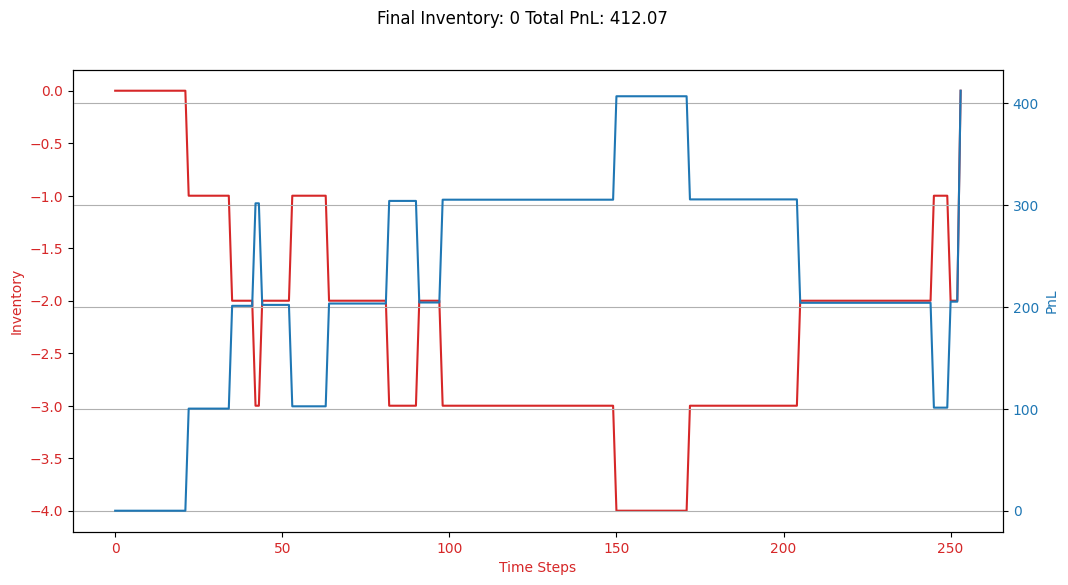

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def stream_prices(price, spread):
    bid = price * (1 - spread / 2)
    ask = price * (1 + spread / 2)
    return bid, ask

def simulate_trading(trade_probability, prices):
    # Initialize running totals
    inventory = 0
    pnl = 0
    inv_hist = []
    pnl_hist = []
    spread = 0.01
    
    for price in prices:
        bid, ask = stream_prices(price, spread)
        # Decide if a trade occurs
        if np.random.rand() < trade_probability:
            if np.random.choice(2) == 1:
                # Client buys from MM
                inventory -= 1
                pnl += ask  # Selling at ask increases P&L
            else:
                # Client sells to MM
                inventory += 1
                pnl -= bid  # Buying at bid decreases P&L
        inv_hist.append(inventory)
        pnl_hist.append(pnl)

    if(inventory > 0):
        pnl += prices[-1] * inventory
    elif(inventory < 1):
        pnl -= prices[-1] * inventory
    inventory = 0

    inv_hist.append(inventory)
    pnl_hist.append(pnl)
    
    title = f'Final Inventory: {inventory} Total PnL: {"{:.2f}".format(pnl)}'

    fig, ax1 = plt.subplots(figsize=(12,6))

    color = 'tab:red'
    ax1.plot(inv_hist, color=color)
    ax1.set_xlabel('Time Steps', color=color)
    ax1.set_ylabel('Inventory', color=color)
    ax1.tick_params(labelcolor=color)

    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.plot(pnl_hist, color=color)
    ax2.set_ylabel('PnL', color=color)
    ax2.tick_params(labelcolor=color)

    fig.suptitle(title)
    plt.grid(True)
    plt.show()

simulate_trading(0.05, price_action)

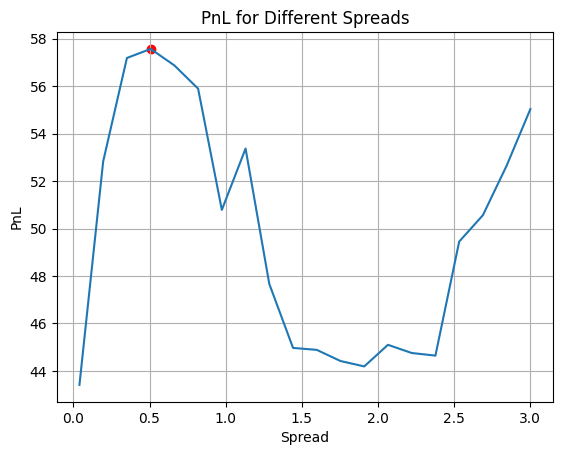

In [29]:
plt.close('all')


# Define parameters
sigma = 0.5

min_half_spread = 0.02
max_half_spread = 1.5
 # range of spreads to be tested
spreads = np.linspace(min_half_spread * 2 , max_half_spread * 2, 20) 

# Negative for readability
commission = -0.45

# time parameteres
num_sequences = 20
num_ticks = 500

# impact of client trades on mid price
markout = 0.05  
 # probability of trade in the next tick - constant for now 
probability_of_trade = 0.05

# Generate the price actions by taking the cumulative sum of the changes
price_movements = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))
price_actions = np.cumsum(price_movements, axis=1)

# Create a sequence of client trades by drawing from binomial distribution
client_trades = np.random.binomial(1, probability_of_trade, size=(num_sequences, num_ticks))
# Random trade direction 1 for buy, -1 for sell
client_trade_directions = np.random.choice([1, -1], size=(num_sequences, num_ticks))

# Apply client trades impact to price action
for i in range(num_sequences):
    price_actions[i] += np.cumsum(client_trades[i] * client_trade_directions[i] * markout)


def simulate_trading(price_actions, spread, client_trades, client_trade_directions):
    pnl = 0.0
    position = 0
    ask = bid = price_actions[0]

    for i in range(1, len(price_actions)):
        mid_price = price_actions[i]
        # Bid/Ask MM offers
        ask = price_actions[i-1] + spread / 2.0
        bid = price_actions[i-1] - spread / 2.0
        client_trade = client_trades[i]
        client_trade_direction = client_trade_directions[i]

        # Market Maker is short
        if position == -1:  
            # Client trades with us or our bid is hit (mid crosses bid)
            if (client_trade and client_trade_direction == -1) or mid_price <= bid:
                pnl -= 2 * (bid + commission)
                position = 1
            continue
        # Market Maker is long
        elif position == 1:  
             # Client trades with us or our ask is hit (mid crosses ask)
            if (client_trade and client_trade_direction == 1) or mid_price >= ask: 
                pnl += 2* (ask - commission)  # Trading 2 units to close the long position *and* open a new short position
                position = -1
            continue

        elif position == 0:
             # Take on any position since our risk is flat
            if (client_trade and client_trade_direction == 1) or mid_price >= ask:  
                pnl += (ask - commission)
                position = -1
            elif (client_trade and client_trade_direction == -1) or mid_price <= bid:
                pnl -= (bid + commission)
                position = 1
            continue

    # Close remaning open positions 
    if position != 0:
        pnl += position * price_actions[-1] - commission
        position = 0

    return pnl

# Iterate over each spread and each sequence, accumulating PnL for each spread
pnls = np.zeros_like(spreads)
for i, spread in enumerate(spreads):
    for j, seq in enumerate(price_actions):
        pnls[i] += simulate_trading(seq, spread, client_trades[j], client_trade_directions[j])

pnls = pnls / num_sequences

# Plot the results
plt.plot(spreads, pnls)
plt.scatter(spreads[np.argmax(pnls)], pnls.max(), color='r')  # Mark the max PnL
plt.title("PnL for Different Spreads")
plt.xlabel("Spread")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

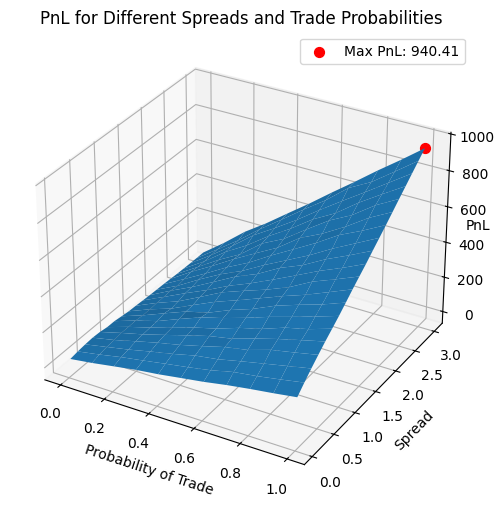

In [31]:
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
probability_of_trades = np.linspace(0.0, 1.0, 11) 
pnls_surface = np.zeros((len(spreads), len(probability_of_trades)))

price_movements = np.random.normal(scale=sigma, size=(num_sequences, num_ticks))


# Generate the price actions by taking the cumulative sum of the price movements
price_actions = np.cumsum(price_movements, axis=1)


def calc(pnls_surface, initial_price_actions, markout):
    for i, spread in enumerate(spreads):
        for j, probability_of_trade in enumerate(probability_of_trades):
            client_trades = np.random.binomial(1, probability_of_trade, size=(num_sequences, num_ticks))
            sequences = np.copy(initial_price_actions)
            for k, seq in enumerate(sequences):
                # Apply client trades impact to price
                sequences[k] += np.cumsum(client_trades[k] * client_trade_directions[k] * markout)
                pnls_surface[i, j] += simulate_trading(seq, spread, client_trades[k], client_trade_directions[k])
            pnls_surface[i, j] /= num_sequences
    return pnls_surface


# Save a copy of the initial sequences
initial_sequences = np.copy(price_actions)

# Use the initial sequences in the calculation
pnls_surface = calc(pnls_surface, initial_sequences, markout)


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(probability_of_trades, spreads)
ax.plot_surface(X, Y, pnls_surface)
ax.set_xlabel('Probability of Trade')
ax.set_ylabel('Spread')
ax.set_zlabel('PnL', labelpad=-7)
ax.set_title('PnL for Different Spreads and Trade Probabilities')

# Find the maximum PnL and its corresponding indices
max_pnl_index = np.unravel_index(np.argmax(pnls_surface, axis=None), pnls_surface.shape)
max_spread = spreads[max_pnl_index[0]]
max_probability_of_trade = probability_of_trades[max_pnl_index[1]]
max_pnl = pnls_surface[max_pnl_index]

# Mark the maximum PnL on the plot
ax.scatter(max_probability_of_trade, max_spread, max_pnl, color='r', s=50, label=f'Max PnL: {max_pnl:.2f}')
ax.legend()

plt.show()